In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

from backtester.trading_system_parameters import TradingSystemParameters
from datetime import timedelta
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from backtester.dataSource.nse_data_source import NSEStockDataSource
from backtester.executionSystem.simple_execution_system import SimpleExecutionSystem
from backtester.executionSystem.pair_execution_system import PairExecutionSystem
from backtester.orderPlacer.backtesting_order_placer import BacktestingOrderPlacer
from backtester.trading_system import TradingSystem
from backtester.constants import *
from backtester.timeRule.us_time_rule import USTimeRule
from backtester.features.feature import Feature

In [4]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [5]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2020/05/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','GOOGL','AMZN','MSFT','INTC','AMD','KO','PEP','MCD','SBUX','CMG']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: GOOGL
Processing data for stock: AMZN
Processing data for stock: MSFT
Processing data for stock: INTC
Processing data for stock: AMD
Processing data for stock: KO
Processing data for stock: PEP
Processing data for stock: MCD
Processing data for stock: SBUX
Processing data for stock: CMG
20% done...
40% done...
60% done...
80% done...


In [6]:
data.head(3)

,SPY,AAPL,GOOGL,AMZN,MSFT,INTC,AMD,KO,PEP,MCD,SBUX,CMG
2007-11-30,114.876030,22.535343,346.846832,90.559998,25.232943,17.831505,9.76,18.515615,53.202648,40.145603,9.874459,133.149994
2007-12-03,114.118706,22.119802,341.106110,90.910004,24.722271,17.947742,9.66,18.545437,52.789074,41.079380,9.629601,132.929993
2007-12-04,113.098663,22.237297,342.422424,94.410004,24.609631,17.988766,9.25,18.709425,52.837307,41.216698,9.431180,137.509995


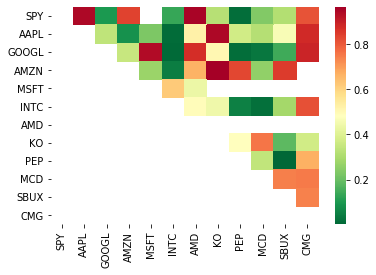

[('SPY', 'PEP'), ('AAPL', 'INTC'), ('GOOGL', 'INTC'), ('GOOGL', 'PEP'), ('GOOGL', 'MCD'), ('AMZN', 'INTC'), ('INTC', 'MCD'), ('PEP', 'SBUX')]


In [7]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

0.7050718028406542 -1.6368878203526476


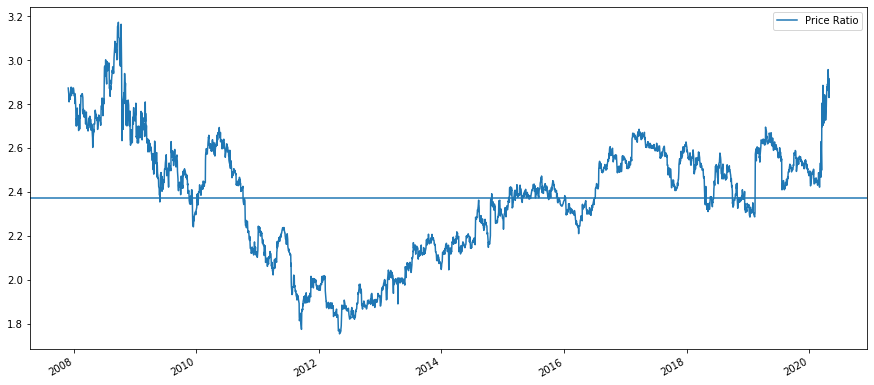

In [23]:
S1 = data['PEP']
S2 = data['KO']
score, pvalue, _ = coint(S1, S2)
print(pvalue, score)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [24]:
def zscore(series, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = series.rolling(window=window1,
                               center=False).mean()
    ma2 = series.rolling(window=window2,
                               center=False).mean()
    std = series.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    return zscore

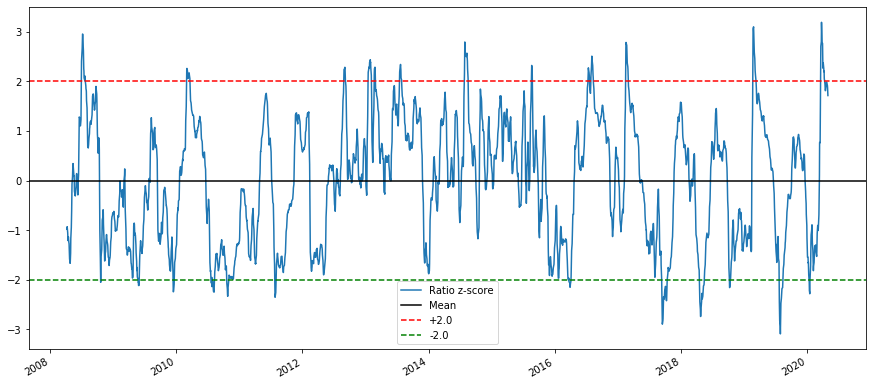

In [25]:
zscore(ratios, 6, 90).plot(figsize=(15,7))
plt.axhline(zscore(ratios, 6, 90).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+2.0', '-2.0'])
plt.show()

In [ ]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

In [5]:
class PairValuePredictionFeature(Feature):

    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
    # def computeForMarket(cls, updateNum, time, featureParams, featureKey, currentMarketFeatures, instrumentManager):
        lookbackMarketFeatures = instrumentManager.getDataDf()

        prediction = pd.Series(0.5, index = instrumentManager.getAllInstrumentsByInstrumentId())
        if len(lookbackMarketFeatures)>0:
            currentMarketFeatures = lookbackMarketFeatures.iloc[-1]
            # IMPLEMENT THIS
            z_score = pd.Series(index = PAIRIDS.keys())
            for i in PAIRIDS.keys():
                if currentMarketFeatures['sdev_r%s_90'%i] != 0:
                  z_score[i] = (currentMarketFeatures['ma_r%s_10'%i] - currentMarketFeatures['ma_r%s_90'%i]) / currentMarketFeatures['sdev_r%s_90'%i]
                else:
                  z_score[i] = 0
                instrument = instrumentManager.getInstrument(instrumentIds[0])
                #z_score = z_score + instrument.getDataDf()['position']/20000

                if currentMarketFeatures['correl_r%s_90'%i] < 0.5:
                  z_score[i] = 0


                if z_score[i] > 1:
                    prediction[PAIRIDS[i][0]] = 0
                    prediction[PAIRIDS[i][1]] = 1
                elif z_score[i] < -1:
                    prediction[PAIRIDS[i][0]] = 1
                    prediction[PAIRIDS[i][1]] = 0
                elif (z_score[i] > 0.5) or (z_score[i] < -0.5) :
                    prediction[PAIRIDS[i][0]] = 0.75
                    prediction[PAIRIDS[i][1]] = 0.25
                else:
                    prediction[PAIRIDS[i][0]] = 0.5
                    prediction[PAIRIDS[i][1]] = 0.5

        return prediction

In [2]:
class MyTradingParams(TradingSystemParameters):
    
    def __init__(self, instrumentIds, shortPeriod, longPeriod, startDate, endDate, benchMarkId):
        self.count = 0
        self.params = {}
        self.start = startDate
        self.end = endDate
        self.instrumentIds = instrumentIds
        self.shortPeriod = shortPeriod
        self.longPeriod = longPeriod
        self.benchMarkId = benchMarkId
        super(MyTradingParams, self).__init__()
    '''
    Returns an instance of class DataParser. Source of data for instruments
    '''

    def getDataParser(self):
        return YahooStockDataSource(cachedFolderName='yahooData/',
                                     dataSetId='testPairsTrading',
                                     instrumentIds=self.instrumentIds + [self.benchMarkId],
                                     startDateStr=self.start,
                                     endDateStr=self.end)

    '''
    This is a way to use any custom features you might have made.
    Returns a dictionary where
    key: featureId to access this feature (Make sure this doesnt conflict with any of the pre defined feature Ids)
    value: Your custom Class which computes this feature. The class should be an instance of Feature
    Eg. if your custom class is MyCustomFeature, and you want to access this via featureId='my_custom_feature',
    you will import that class, and return this function as {'my_custom_feature': MyCustomFeature}
    '''

    def getBenchmark(self):
        return self.benchMarkId

    def getTimeRuleForUpdates(self):
        return USTimeRule(startDate = self.start,
                          endDate = self.end)

    '''
    Returns a dictionary with:
    key: string representing instrument type. Right now INSTRUMENT_TYPE_OPTION, INSTRUMENT_TYPE_STOCK, INSTRUMENT_TYPE_FUTURE
    value: Array of instrument feature config dictionaries
        feature config Dictionary has the following keys:
        featureId: a string representing the type of feature you want to use
        featureKey: {optional} a string representing the key you will use to access the value of this feature.
                    If not present, will just use featureId
        params: {optional} A dictionary with which contains other optional params if needed by the feature
    Example:
    positionConfigDict = {'featureId': 'position'}
    vwapConfigDict = {'featureKey': 'price',
                          'featureId': 'vwap'}
    movingAvg_30Dict = {'featureKey': 'mv_avg_30',
                          'featureId': 'moving_average',
                          'params': {'days': 30}}
    movingAvg_90Dict = {'featureKey': 'mv_avg_90',
                          'featureId': 'moving_average',
                          'params': {'days': 90}}
    return {INSTRUMENT_TYPE_FUTURE: [positionConfigDict, vwapConfigDict],
            INSTRUMENT_TYPE_STOCK: [positionConfigDict, movingAvg_30Dict, movingAvg_90Dict]}

    For each future instrument, you will have features keyed by position and price.
    For each stock instrument, you will have features keyed by position, mv_avg_30, mv_avg_90
    '''

    def getInstrumentFeatureConfigDicts(self):
        print(self)
        # ADD RELEVANT FEATURES HERE
        maLongDict = {'featureKey': 'ma_long',
                   'featureId': 'moving_average',
                   'params': {'period': self.longPeriod,
                              'featureName': 'adjClose'}}
        maShortDict = {'featureKey': 'ma_short',
                   'featureId': 'moving_average',
                   'params': {'period': self.shortPeriod,
                              'featureName': 'adjClose'}}
        position = {'featureKey': 'position',
                    'featureId': 'position',
                    'params': {}}
        predictionDict = {'featureKey': 'prediction',
                                'featureId': 'prediction',
                                'params': {}}

        return {INSTRUMENT_TYPE_STOCK: [maLongDict, maShortDict, position, predictionDict]}

    '''
    Returns an array of market feature config dictionaries
        market feature config Dictionary has the following keys:
        featureId: a string representing the type of feature you want to use
        featureKey: a string representing the key you will use to access the value of this feature.this
        params: A dictionary with which contains other optional params if needed by the feature
    '''

    def getMarketFeatureConfigDicts(self):
        # ADD RELEVANT FEATURES HERE

        # customFeatureDict = {'featureKey': 'custom_mrkt_feature',
        #                      'featureId': 'my_custom_mrkt_feature',
        #                      'params': {'param1': 'value1'}}
        return []
    
    def getPrediction(self, time, currentMarketFeatures, instrumentManager):
        lookbackInstrumentFeatures = instrumentManager.getLookbackInstrumentFeatures()
        
        maLongData = lookbackInstrumentFeatures.getFeatureDf('ma_long')
        
        print(maLongData)

        
        return [0.5, 0.5, 0.5]

    '''
    Returns the type of execution system we want to use. Its an implementation of the class ExecutionSystem
    It converts prediction to intended positions for different instruments.
    '''

    def getExecutionSystem(self):
        # return PairExecutionSystem(pair=[instrumentIds[0], instrumentIds[1]],
        #                            pairRatio=0.3,
        #                            pairEnter_threshold=0.7,
        #                            pairExit_threshold=0.55,
        #                            pairLongLimit=20000,
        #                            pairShortLimit=20000,
        #                            pairCapitalUsageLimit = 0.10*self.getStartingCapital(),
        #                            pairLotSize=200)
        return SimpleExecutionSystem(enter_threshold=0.7, exit_threshold=0.55,
                                    longLimit=10000,shortLimit=10000, capitalUsageLimit=.85,
                                    enterlotSize=10000, exitlotSize = 10000, limitType='D', price='adjClose')


            # enter_threshold=0.7,
            #                          exit_threshold=0.55,
            #                          longLimit={'ADANIPOWER.BO': 100,'RPOWER.BO': 100 * ratio},
            #                          shortLimit={'ADANIPOWER.BO': -100,'RPOWER.BO': -100 * ratio},
            #                          lotSize={'ADANIPOWER.BO': 10,'RPOWER.BO': 10 * ratio})

    '''
    Returns the type of order placer we want to use. its an implementation of the class OrderPlacer.
    It helps place an order, and also read confirmations of orders being placed.
    For Backtesting, you can just use the BacktestingOrderPlacer, which places the order which you want, and automatically confirms it too.
    '''

    def getOrderPlacer(self):
        return BacktestingOrderPlacer()

    '''
    Returns the amount of lookback data you want for your calculations. The historical market features and instrument features are only
    stored upto this amount.
    This number is the number of times we have updated our features.
    '''

    def getLookbackSize(self):
        return 90

In [3]:
tsParams = MyTradingParams(['AAPL', 'GOOGL'], 6, 90, '2007/12/01', '2009/12/01', 'SPY')
tradingSystem = TradingSystem(tsParams)
tradingSystem.startTrading(onlyAnalyze=False)

Processing data for stock: AAPL
Processing data for stock: GOOGL
Processing data for stock: SPY
20% done...
40% done...
60% done...
80% done...
2007-12-03 09:30:00
Error: prediction not a valid feature Id. Use a predefined one or provide a custom implementation


NotImplementedError: 